In [ ]:
!pip install imbalanced-learn

In [ ]:
# core libraries
import numpy as np 
import pandas as pd

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import plotly.express as px
import plotly

# Outliers detection
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from scipy.spatial.distance import pdist, mahalanobis, squareform
from scipy.stats import chi2

# libraries for data preparation
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, QuantileTransformer, FunctionTransformer, OneHotEncoder

# model selection and evaluation
from sklearn.model_selection import  train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import r2_score, classification_report, make_scorer, f1_score

# supportive libraries
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tqdm.notebook import tqdm as tqdm
import itertools

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("drive/MyDrive/training/HW/data/Cardiotocography.csv")
df

,id,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,DP,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,outlier
0,1881.0,0.592593,0.000000,0.000000,0.294118,0.633803,0.338235,0.000000,0.013807,0.500000,0.0,0.000000,0.595376,0.045872,0.336207,0.333333,0.1,0.485149,0.247423,0.284091,0.638418,1.0,b'yes'
1,421.0,0.574074,0.038462,0.000000,0.000000,0.816901,0.029412,0.527473,0.092702,0.000000,0.0,0.000000,0.364162,0.770642,0.672414,0.166667,0.0,0.534653,0.587629,0.511364,0.016949,0.0,b'yes'
2,92.0,0.777778,0.000000,0.000000,0.000000,0.774648,0.029412,0.736264,0.096647,0.000000,0.0,0.000000,0.069364,0.816514,0.275862,0.222222,0.0,0.633663,0.659794,0.602273,0.000000,1.0,b'yes'
3,1767.0,0.259259,0.000000,0.000000,0.294118,0.704225,0.191176,0.000000,0.183432,0.428571,0.0,0.333333,0.473988,0.174312,0.275862,0.222222,0.1,0.000000,0.164948,0.000000,0.361582,0.0,b'yes'
4,1880.0,0.592593,0.000000,0.001773,0.294118,0.633803,0.352941,0.000000,0.013807,0.428571,0.0,0.333333,0.595376,0.045872,0.336207,0.333333,0.1,0.485149,0.226804,0.272727,0.683616,1.0,b'yes'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16875,2118.0,0.629630,0.000000,0.000000,0.352941,0.893333,0.014706,0.253165,0.167653,0.000000,0.0,0.000000,0.096386,0.678899,0.241379,0.055556,0.0,0.641667,0.642202,0.563830,0.005650,1.0,b'no'
16876,2119.0,0.629630,0.000000,0.000000,0.411765,0.893333,0.044118,0.329114,0.138067,0.071429,0.0,0.000000,0.066265,0.724771,0.241379,0.055556,0.0,0.650000,0.633028,0.563830,0.011299,1.0,b'no'
16877,2120.0,0.629630,0.000000,0.000000,0.352941,0.893333,0.058824,0.341772,0.126233,0.071429,0.0,0.000000,0.096386,0.678899,0.241379,0.055556,0.0,0.641667,0.623853,0.563830,0.005650,1.0,b'no'
16878,2121.0,0.629630,0.000000,0.000000,0.235294,0.866667,0.073529,0.215190,0.118343,0.071429,0.0,0.000000,0.126506,0.678899,0.284483,0.111111,0.0,0.650000,0.642202,0.563830,0.011299,0.5,b'no'


# EDA and Data Preparation

In [ ]:
d = {"b'yes'" : 1, "b'no'" : 0}

In [ ]:
df['outlier'] = df['outlier'].map(d)
df

,id,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,DP,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,outlier
0,1881.0,0.592593,0.000000,0.000000,0.294118,0.633803,0.338235,0.000000,0.013807,0.500000,0.0,0.000000,0.595376,0.045872,0.336207,0.333333,0.1,0.485149,0.247423,0.284091,0.638418,1.0,1
1,421.0,0.574074,0.038462,0.000000,0.000000,0.816901,0.029412,0.527473,0.092702,0.000000,0.0,0.000000,0.364162,0.770642,0.672414,0.166667,0.0,0.534653,0.587629,0.511364,0.016949,0.0,1
2,92.0,0.777778,0.000000,0.000000,0.000000,0.774648,0.029412,0.736264,0.096647,0.000000,0.0,0.000000,0.069364,0.816514,0.275862,0.222222,0.0,0.633663,0.659794,0.602273,0.000000,1.0,1
3,1767.0,0.259259,0.000000,0.000000,0.294118,0.704225,0.191176,0.000000,0.183432,0.428571,0.0,0.333333,0.473988,0.174312,0.275862,0.222222,0.1,0.000000,0.164948,0.000000,0.361582,0.0,1
4,1880.0,0.592593,0.000000,0.001773,0.294118,0.633803,0.352941,0.000000,0.013807,0.428571,0.0,0.333333,0.595376,0.045872,0.336207,0.333333,0.1,0.485149,0.226804,0.272727,0.683616,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16875,2118.0,0.629630,0.000000,0.000000,0.352941,0.893333,0.014706,0.253165,0.167653,0.000000,0.0,0.000000,0.096386,0.678899,0.241379,0.055556,0.0,0.641667,0.642202,0.563830,0.005650,1.0,0
16876,2119.0,0.629630,0.000000,0.000000,0.411765,0.893333,0.044118,0.329114,0.138067,0.071429,0.0,0.000000,0.066265,0.724771,0.241379,0.055556,0.0,0.650000,0.633028,0.563830,0.011299,1.0,0
16877,2120.0,0.629630,0.000000,0.000000,0.352941,0.893333,0.058824,0.341772,0.126233,0.071429,0.0,0.000000,0.096386,0.678899,0.241379,0.055556,0.0,0.641667,0.623853,0.563830,0.005650,1.0,0
16878,2121.0,0.629630,0.000000,0.000000,0.235294,0.866667,0.073529,0.215190,0.118343,0.071429,0.0,0.000000,0.126506,0.678899,0.284483,0.111111,0.0,0.650000,0.642202,0.563830,0.011299,0.5,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16880 entries, 0 to 16879
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        16880 non-null  float64
 1   LB        16880 non-null  float64
 2   AC        16880 non-null  float64
 3   FM        16880 non-null  float64
 4   UC        16880 non-null  float64
 5   ASTV      16880 non-null  float64
 6   MSTV      16880 non-null  float64
 7   ALTV      16880 non-null  float64
 8   MLTV      16880 non-null  float64
 9   DL        16880 non-null  float64
 10  DS        16880 non-null  float64
 11  DP        16880 non-null  float64
 12  Width     16880 non-null  float64
 13  Min       16880 non-null  float64
 14  Max       16880 non-null  float64
 15  Nmax      16880 non-null  float64
 16  Nzeros    16880 non-null  float64
 17  Mode      16880 non-null  float64
 18  Mean      16880 non-null  float64
 19  Median    16880 non-null  float64
 20  Variance  16880 non-null  fl

We don't need id for predicting.

In [ ]:
df.drop('id', axis=1, inplace=True)

In [ ]:
X, y = df.drop('outlier', axis=1), df['outlier']

In [ ]:
y.value_counts()

0    16550
1      330
Name: outlier, dtype: int64

In [ ]:
df.describe()

,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,DP,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,outlier
count,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000
mean,0.483186,0.129270,0.011411,0.226668,0.425672,0.179521,0.064739,0.170819,0.113227,0.000770,0.017417,0.391083,0.379411,0.365604,0.230579,0.033365,0.563887,0.525497,0.475086,0.090984,0.670794,0.019550
std,0.175738,0.143077,0.060514,0.156665,0.216970,0.121198,0.146732,0.114551,0.171935,0.027742,0.084956,0.214992,0.252147,0.153285,0.159211,0.069209,0.128429,0.136375,0.146790,0.119737,0.295171,0.138451
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.351852,0.000000,0.000000,0.117647,0.236111,0.088235,0.000000,0.094675,0.000000,0.000000,0.000000,0.204678,0.155963,0.258621,0.111111,0.000000,0.482143,0.431193,0.373494,0.015385,0.500000,0.000000
50%,0.481481,0.076923,0.000000,0.235294,0.408451,0.161765,0.000000,0.155819,0.000000,0.000000,0.000000,0.377907,0.376147,0.353448,0.222222,0.000000,0.567797,0.525773,0.478261,0.045198,0.500000,0.000000
75%,0.592593,0.192308,0.003546,0.304348,0.608108,0.220588,0.050633,0.226824,0.214286,0.000000,0.000000,0.549133,0.596330,0.456897,0.333333,0.000000,0.650000,0.621053,0.576087,0.122677,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We can look through the distributions of features. Some of them have large amout of near-to-zero values. 

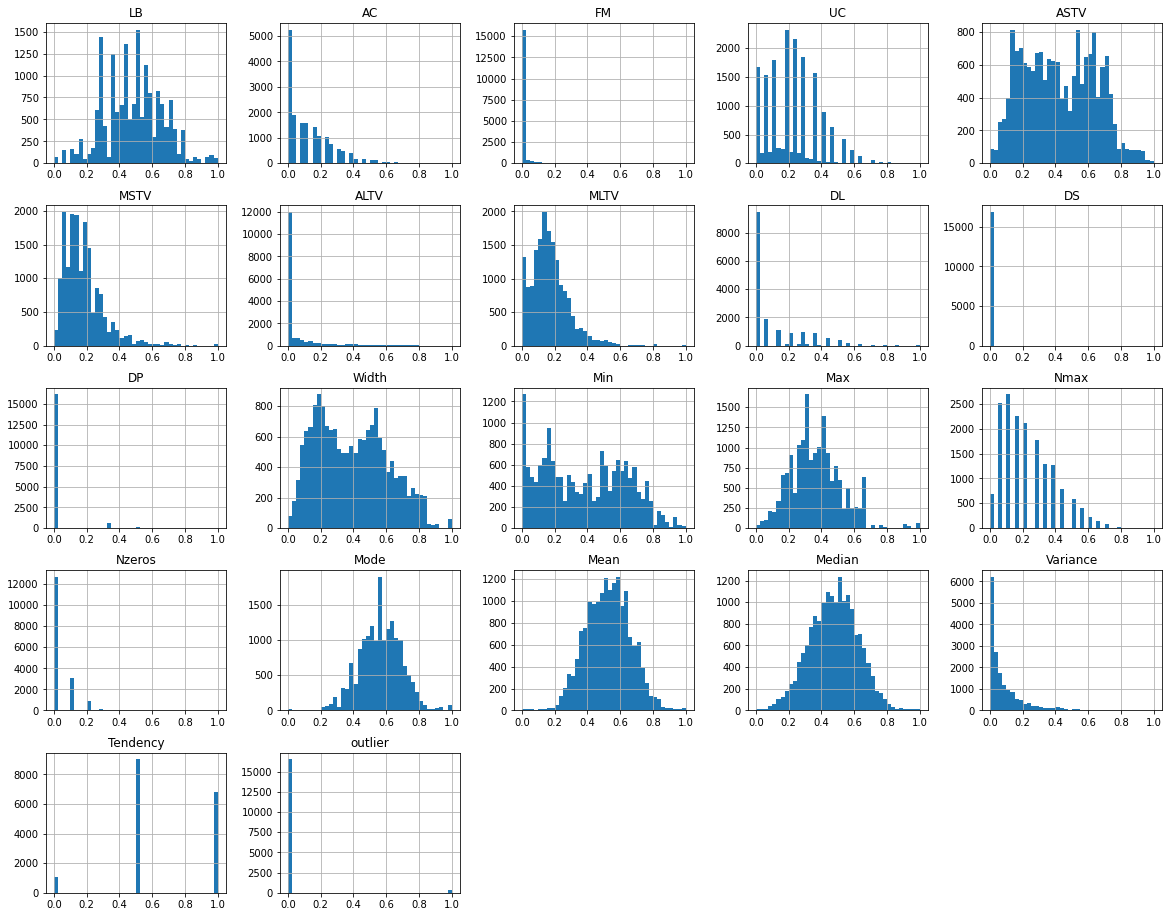

In [ ]:
df.hist(figsize=(20, 16), bins=40);

Let's check some suspicious features.

In [ ]:
for feature in ['FM', 'DS', 'DP']:
  print(feature)
  print(df[feature].value_counts())
  print()

FM
0.000000    10887
0.001773     1416
0.003546      920
0.005319      608
0.007092      521
            ...  
0.287234        2
0.539007        2
0.258865        1
0.785461        1
0.342199        1
Name: FM, Length: 87, dtype: int64

DS
0.0    16867
1.0       13
Name: DS, dtype: int64

DP
0.000000    16127
0.333333      572
0.500000      142
0.666667       20
1.000000       19
Name: DP, dtype: int64



DS has too little unique values, we can drop it.

In [ ]:
df.drop('DS', axis=1, inplace=True)

KeyError: ignored

In [ ]:
# cols_num = 5
# leng = df.drop('outlier', axis=1).columns.shape[0]
# fig, axes = plt.subplots( int(np.ceil(leng / cols_num)) , cols_num,
#                          sharex=False, figsize=(20, 10 * leng // cols_num))


# for i, feature in enumerate(df.drop('outlier', axis=1).columns):
#     sns.violinplot(ax=axes[i // cols_num, i % cols_num], x='outlier', y=feature , data=df);
#     axes[i // cols_num, i % cols_num].set_title(feature)


Let's build pipeline for data preparation.

In [ ]:
quant_list = ['LB', 'ASTV', 'MSTV', 'MLTV', 'Width', 'Min', 'Max', 'Median', 'Variance', 'Mean', 'Mode']
std_list = [ 'FM', 'ALTV', 'DL', 'DP', 'Nzeros', 'Tendency', 'UC', 'AC', 'Nmax']

quant_pipe = Pipeline([
    ('quant', QuantileTransformer(output_distribution='normal', n_quantiles=100)),
])

std_pipe = Pipeline([
    ('scaler', StandardScaler()),
])

pipe = ColumnTransformer(transformers=[
    ('quant', quant_pipe, quant_list),
    ('std', std_pipe, std_list)
], verbose=False)

In [ ]:
X_scaled = pd.DataFrame(pipe.fit_transform(X), columns=quant_list+std_list)

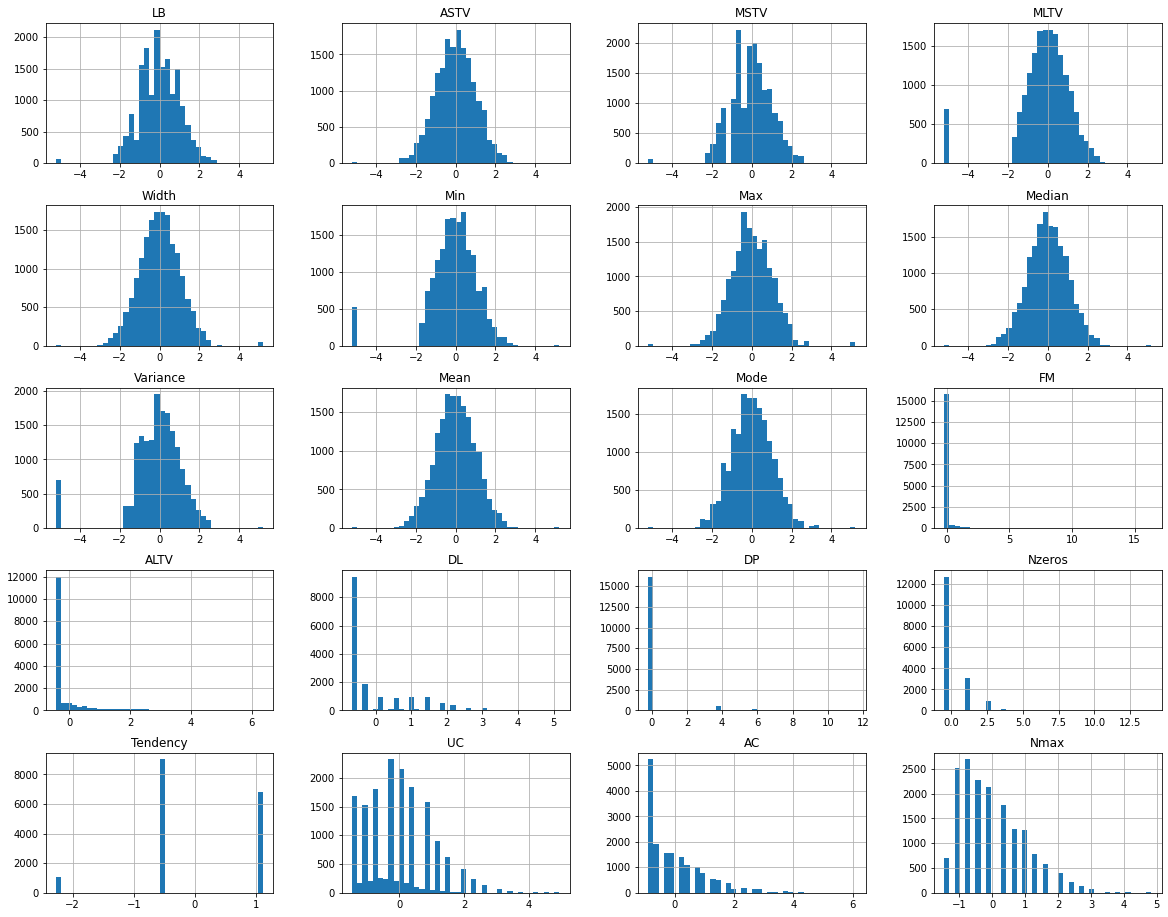

In [ ]:
X_scaled.hist(figsize=(20, 16), bins=40);

# Mahalanobis

Firstly we will try to find outliers using Mahalanobis rule. After that, we will use some information from this in our further investigations.

In [ ]:
covariance_inverse = np.linalg.inv(np.cov(X_scaled.T))
mean_vector = X_scaled.mean(axis=0)

bias_distance = X_scaled.apply(lambda row:
                             mahalanobis(mean_vector, row, VI=covariance_inverse), 
                             axis=1)

In [ ]:
pvals = 1 - chi2.cdf(bias_distance**2, df=X_scaled.shape[1])

predictions = np.zeros(X_scaled.shape[0])
predictions[pvals < 0.001] = 1

In [ ]:
set(predictions)

{0.0, 1.0}

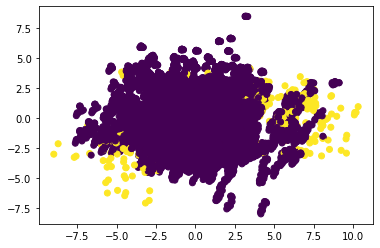

In [ ]:
X_scaled_reduced = PCA().fit_transform(X_scaled)
plt.scatter(X_scaled_reduced[:,0], X_scaled_reduced[:,1], c=y);
plt.show()

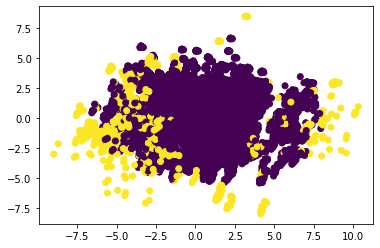

In [ ]:
X_scaled_reduced = PCA().fit_transform(X_scaled)
plt.scatter(X_scaled_reduced[:,0], X_scaled_reduced[:,1], c=predictions);
plt.show()

In [ ]:
def report(y_data, predictions, outlier_label =-1):
  predictions = predictions.copy()

  predictions[predictions != outlier_label] = 0
  predictions[predictions == outlier_label] = 1


  print(classification_report(y_data, predictions))

In [ ]:
report(df['outlier'], predictions, outlier_label=1)

              precision    recall  f1-score   support

           0       0.99      0.94      0.96     16550
           1       0.12      0.41      0.18       330

    accuracy                           0.93     16880
   macro avg       0.55      0.67      0.57     16880
weighted avg       0.97      0.93      0.95     16880



# Supervised

In [ ]:
X['bias'] = bias_distance

In [ ]:
quant_list = ['LB', 'ASTV', 'MSTV', 'MLTV', 'Width', 'Min', 'Max', 'Median', 'Variance', 'Mean', 'Mode', 'bias']
std_list = [ 'FM', 'ALTV', 'DL', 'DP', 'Nzeros', 'Tendency', 'UC', 'AC', 'Nmax']

quant_pipe = Pipeline([
    ('quant', QuantileTransformer(output_distribution='normal', n_quantiles=100)),
])

std_pipe = Pipeline([
    ('scaler', StandardScaler()),
])

pipe = ColumnTransformer(transformers=[
    ('quant', quant_pipe, quant_list),
    ('std', std_pipe, std_list)
], verbose=False)

In [ ]:
X_scaled = pd.DataFrame(pipe.fit_transform(X), columns=quant_list+std_list)

The main metric is F1, because we have highly imbalanced data.

## Logistic Regression

In [ ]:
X_train_scaled, X_test_scaled, y_train, y_test= train_test_split(X_scaled, y, test_size=0.33, random_state=42, stratify=y)

In [ ]:
f1 = make_scorer(f1_score , average='macro')

In [ ]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

pipeline = Pipeline([
    ('estimator', LogisticRegression(max_iter=10000))
])

grid = {
    'estimator__C': np.linspace(0, 1, 100),
}

gs = GridSearchCV(pipeline, grid, 
                  n_jobs=-1, 
                  scoring=f1,
                  cv=cv,
                  verbose=10)

In [ ]:
gs.fit(X_train_scaled, y_train)
y_p = gs.predict(X_test_scaled)
print(classification_report(y_test , y_p))
print(f1_score(y_test, y_p))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1919s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1877s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 166 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 262 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   12.2s finished


              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5462
           1       0.80      0.40      0.54       109

    accuracy                           0.99      5571
   macro avg       0.89      0.70      0.76      5571
weighted avg       0.98      0.99      0.98      5571

0.5365853658536586


In [ ]:
gs.best_params_

{'estimator__C': 0.36363636363636365}

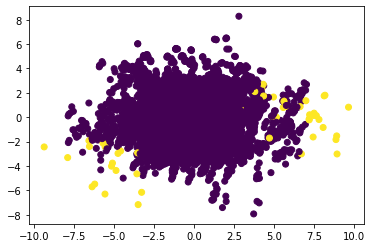

In [ ]:
X_test_scaled_reduced = PCA().fit_transform(X_test_scaled)
plt.scatter(X_test_scaled_reduced[:,0], X_test_scaled_reduced[:,1], c=y_p);
plt.show()

## SVM

In [ ]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

pipeline = Pipeline([
    ('estimator', SVC())
])

grid = {
    'estimator__C': np.linspace(0, 1, 100),
    'estimator__kernel' : ['linear', 'poly', 'rbf']
}

gs = GridSearchCV(pipeline, grid, 
                  n_jobs=-1, 
                  scoring=f1,
                  cv=cv,
                  verbose=10)

In [ ]:
gs.fit(X_train_scaled, y_train)
y_p = gs.predict(X_test_scaled) 
print(classification_report(y_test , y_p))
print(f1_score(y_test, y_p))

Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0222s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0411s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 356 tasks      | elapsed:   37.7s
[Parallel(n_jo

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5462
           1       1.00      0.58      0.73       109

    accuracy                           0.99      5571
   macro avg       1.00      0.79      0.86      5571
weighted avg       0.99      0.99      0.99      5571

0.7325581395348838


In [ ]:
gs.best_params_

{'estimator__C': 1.0, 'estimator__kernel': 'poly'}

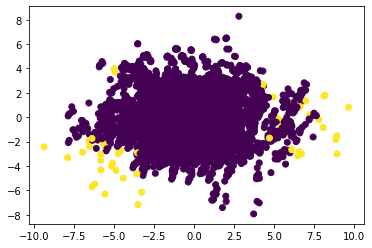

In [ ]:
X_test_scaled_reduced = PCA().fit_transform(X_test_scaled)
plt.scatter(X_test_scaled_reduced[:,0], X_test_scaled_reduced[:,1], c=y_p);
plt.show()

## KNN

In [ ]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

pipeline = Pipeline([
    ('estimator', KNeighborsClassifier())
])

grid = {
    'estimator__n_neighbors': np.arange(2, 30, 1),
    'estimator__weights' : ['uniform', 'distance']
}

gs = GridSearchCV(pipeline, grid, 
                  n_jobs=-1, 
                  scoring=f1,
                  cv=cv,
                  verbose=10)



In [ ]:
gs.fit(X_train_scaled, y_train)
y_p = gs.predict(X_test_scaled) 
print(classification_report(y_test , y_p))
print(f1_score(y_test, y_p))

Fitting 3 folds for each of 56 candidates, totalling 168 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   46.7s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:   56.3s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  1

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5462
           1       1.00      0.78      0.88       109

    accuracy                           1.00      5571
   macro avg       1.00      0.89      0.94      5571
weighted avg       1.00      1.00      1.00      5571

0.8762886597938144


In [ ]:
gs.best_params_

{'estimator__n_neighbors': 2, 'estimator__weights': 'distance'}

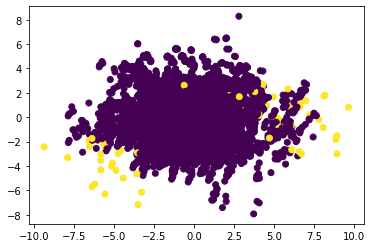

In [ ]:
X_test_scaled_reduced = PCA().fit_transform(X_test_scaled)
plt.scatter(X_test_scaled_reduced[:,0], X_test_scaled_reduced[:,1], c=y_p);
plt.show()

## Best Algorithm

It seems, that KNN showed the best results. Probably, this is related to that this algo analyses the distance between samples.

# Unsupervised

In [ ]:
def f1_score_unsup(y_data, predictions, outlier_label =-1):
  predictions = predictions.copy()

  predictions[predictions != outlier_label] = 0
  predictions[predictions == outlier_label] = 1

  return f1_score(y_data, predictions)

## One-Class SVM

In [ ]:
nu = np.linspace(0.001, 0.2, 10)
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid = itertools.product(nu, kernel)

print('Amount of hyperparameters combinations: {}'.format(len(nu) * len(kernel)))

Amount of hyperparameters combinations: 40


In [ ]:
params_dict = {}

for param_set in tqdm(param_grid, total=len(nu) * len(kernel)):
  clf = OneClassSVM(nu=param_set[0], kernel=param_set[1])
  
  y_p = clf.fit_predict(X_scaled)
  if len(set(y_p)) != 1:
    params_dict['{}_{}'.format( param_set[0], param_set[1])] = (param_set, 
                                                               f1_score_unsup(y, y_p))

  0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
best = max(params_dict.items(), key=lambda x: x[1][1])
best

('0.023111111111111114_rbf',
 ((0.023111111111111114, 'rbf'), 0.24930747922437674))

In [ ]:
clf = OneClassSVM(nu=best[1][0][0], kernel=best[1][0][1])
svm_predictions = clf.fit_predict(X_scaled)

In [ ]:
report(y, svm_predictions)

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     16550
           1       0.23      0.27      0.25       330

    accuracy                           0.97     16880
   macro avg       0.61      0.63      0.62     16880
weighted avg       0.97      0.97      0.97     16880



## One-Class SVM with precomputed kernel

In [ ]:
covariance_inverse = np.linalg.inv(np.cov(X_scaled.T))

codense = pdist(X_scaled, metric='mahalanobis', VI=covariance_inverse)
distance = squareform(codense)

In [ ]:
distance.shape

(16880, 16880)

In [ ]:
nus = np.linspace(0.001, 0.2, 10)

In [ ]:
params_dict = {}
for nu in tqdm(nus):
  clf = OneClassSVM(nu=nu, kernel='precomputed')
  
  y_p = clf.fit_predict(1 / (1 + distance))
  if len(set(y_p)) != 1:
    params_dict['{}'.format(nu)] = (nu, 
                                    f1_score_unsup(y, y_p))

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
best = max(params_dict.items(), key=lambda x: x[1][1])
best

('0.023111111111111114', (0.023111111111111114, 0.24935732647814907))

In [ ]:
clf = OneClassSVM(nu=best[1][0], kernel='precomputed')
svm_predictions = clf.fit_predict(1 / (1 + distance))

In [ ]:
report(y, svm_predictions)
f1_score_unsup(y, svm_predictions)

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     16550
           1       0.22      0.29      0.25       330

    accuracy                           0.97     16880
   macro avg       0.60      0.64      0.62     16880
weighted avg       0.97      0.97      0.97     16880



0.24935732647814907

We can see, that one class svm, built on Mahalonobis distances, showed a little better results.

## Isolation Forest

In [ ]:
n_estimators = np.arange(20, 300, 20)
max_samples = ['auto', 3, 4, 10, 15]
max_features = [1, 2, 5, 10, 15]
param_grid = itertools.product(n_estimators, max_samples, max_features)

print('Amount of hyperparameters combinations: {}'.format(len(n_estimators) * len(max_samples) * len(max_features)))

Amount of hyperparameters combinations: 350


In [ ]:
params_dict = {}

for param_set in tqdm(param_grid, total=len(n_estimators) * len(max_samples) * len(max_features)):
  clf = IsolationForest(n_estimators=param_set[0], max_samples=param_set[1], max_features=param_set[2])
  
  y_p = clf.fit_predict(X_scaled)
  if len(set(y_p)) != 1:
    params_dict['{}_{}'.format( param_set[0], param_set[1])] = (param_set, 
                                                               f1_score_unsup(y, y_p))

  0%|          | 0/350 [00:00<?, ?it/s]

In [ ]:
best = max(params_dict.items(), key=lambda x: x[1][1])
best

('80_auto', ((80, 'auto', 15), 0.23252496433666195))

In [ ]:
clf = IsolationForest(n_estimators=best[1][0][0], max_samples=best[1][0][1], max_features=best[1][0][2])
y_p = clf.fit_predict(X_scaled)

In [ ]:
report(y, y_p)
f1_score_unsup(y, y_p)

              precision    recall  f1-score   support

           0       0.99      0.92      0.95     16550
           1       0.11      0.50      0.18       330

    accuracy                           0.91     16880
   macro avg       0.55      0.71      0.56     16880
weighted avg       0.97      0.91      0.94     16880



0.17780172413793105

## Best algorithm

So, One Class SVM showed better results for our data. 

Unsupervised algorithms showed worse results, but they don't use labels to predict.